In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
from anndata import AnnData

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

import hdf5plugin

In [2]:
path = "../data/brca/tcga/processed/GSE176078/ct_minor/genes_prop_cells_primary_tumor_unstranded_subset_CID3586.csv"
adata = pd.read_csv(path, sep=",").T

In [3]:
adata.head(5)

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RP11-744A16.4,PAUPAR,RP11-65B7.2,GIMAP1-GIMAP5,RP11-274B21.13,AF127936.7,CH17-132F21.5,RP11-439M15.1,LINC01144,RP11-418H16.1
B cells Memory,65158.920757,1005.181063,42190.195304,34329.650952,14094.098671,15358.266029,66419.569737,44514.625047,41606.851341,62143.834206,...,1.770127,63.330040,27.551306,0.0,12.934169,331.492104,8.918660,14.947946,1791.068259,122.143095
B cells Naive,361.001165,1.863320,209.516584,136.645334,51.058173,28.970839,137.592616,333.508025,157.602408,237.779453,...,0.002176,0.014225,0.076922,0.0,0.014222,0.961288,0.030872,0.045062,12.627170,0.870957
T cells CD8+,1831.946972,10.080339,1217.114418,1437.163620,2415.550297,239.535060,2976.009960,1537.583444,2373.284320,3109.810714,...,0.000000,17.021225,2.730522,0.0,6.793981,27.749674,2.483616,1.047659,25.644849,3.902548
T cells CD4+,599.022761,2.474468,454.147104,212.653946,70.232031,39.989713,238.097447,673.472859,740.098514,423.508378,...,0.000000,0.394422,0.121108,0.0,0.003216,1.501675,0.001842,0.044346,30.791485,3.907978
NK cells,273104.911860,11845.974952,188502.000317,162337.193759,65327.298033,29845.768677,225590.926011,176758.397432,207509.150953,276919.028702,...,3.860192,123.013058,121.011013,0.0,74.830287,1669.259304,62.093806,89.796540,7638.430940,424.193195


In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 7 × 54645

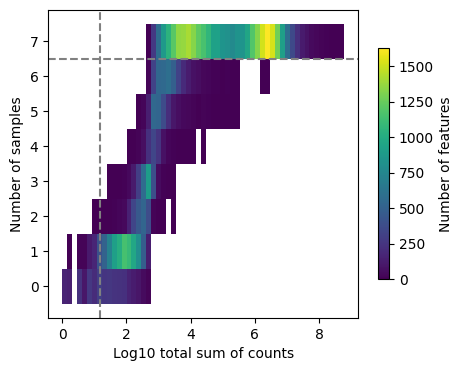

In [5]:
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 7 × 30603

In [7]:
# path = "../data/brca/tcga/processed/GSE176078/ct_minor/genes_prop_cells_primary_tumor_unstranded_subset_CID3586.h5ad"
# adata = sc.read_h5ad(path)

In [8]:
model = dc.get_progeny(organism='human', top=300)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
4195,p53,F5,2.397854,5.746843e-08
4196,p53,MKI67,-5.680340,5.758565e-08
4197,p53,THOC2,-2.108178,5.858359e-08
4198,p53,POLA1,-4.943873,5.911873e-08


In [9]:
pd.unique(model.source)

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

In [10]:
# Infer pathway activities with consensus
dc.run_consensus(mat=adata, 
                 net=model,
                 use_raw=False, 
                 verbose=True)

Running consensus.
Running mlm on mat with 7 samples and 30603 targets for 14 sources.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.10it/s]


Running ulm on mat with 7 samples and 30603 targets for 14 sources.
Running wsum on mat with 7 samples and 30603 targets for 14 sources.
Infering activities on 1 batches.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


In [11]:
adata

AnnData object with n_obs × n_vars = 7 × 30603
    obsm: 'consensus_estimate', 'consensus_pvals'

In [12]:
# Extract from dictionary
acts =  adata.obsm['consensus_estimate']
pvals = adata.obsm['consensus_pvals']

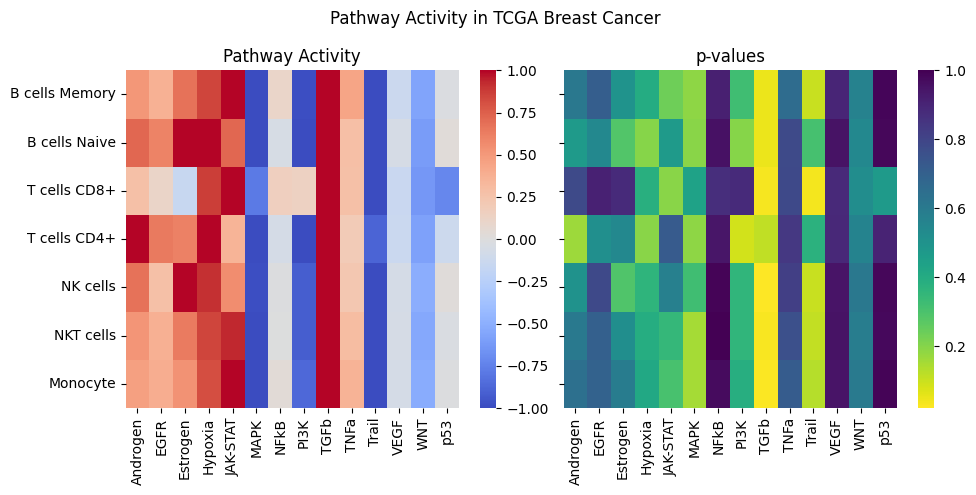

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True, sharey=True)

axes[0].set_title('Pathway Activity')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('p-values')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)
path = "../figures/GSE176078/With_No_Other/Immune_cell_cancer_pathways.png"
fig.suptitle("Pathway Activity in TCGA Breast Cancer")
plt.savefig(path,format='png')
plt.show()
plt.close()

Cells of the immune system, such as B, T, and NK cells, tend to exhibit higher activity in pathways that regulate immune responses, such as TGFb, but lower activity in pathways that induce apoptosis, such as Trail. Interestingly, these same cell types are also involved in the MAPK pathway, which is known to promote cell growth and proliferation.

In [21]:
model.query("source == 'TGFb'").sort_values(by="weight", ascending=False)["target"].head(10)

2413         ID1
2423         ID3
2410        COMP
2432      PMEPA1
2402       SMAD7
2457       RFLNB
2421       FSTL3
2573      AMIGO2
2607    SERPINE1
2551       CTPS1
Name: target, dtype: object

* ID1: Prognostic marker in lung cancer (unfavorable)
* ID3: Prognostic marker in endometrial cancer (favorable)
* COMP: Prognostic marker in renal cancer (unfavorable), colorectal cancer (unfavorable), endometrial cancer (unfavorable) and urothelial cancer (unfavorable)
* PMEPA1: Prognostic marker in renal cancer (unfavorable), lung cancer (unfavorable), cervical cancer (unfavorable) and urothelial cancer (unfavorable) - Cancer enhanced (prostate cancer)
* SMAD7: Prognostic marker in endometrial cancer (unfavorable)

In [22]:
model.query("source == 'MAPK'").sort_values(by="weight", ascending=False)["target"].head(10)

1500     DUSP6
1507     SPRY4
1502     SPRY2
1506     FOSL1
1603      MMP1
1756      IER3
1625      EGR1
1515     DUSP5
1508     DUSP4
1511    PHLDA1
Name: target, dtype: object

* DUSP6: Prognostic marker in endometrial cancer (favorable) - 	Cancer enhanced (thyroid cancer)
* SPRY4: Prognostic marker in renal cancer (unfavorable) and cervical cancer (unfavorable)
* SPRY2:upregulated in colorectal cancer, Lung cancer
* FOSL1:Cancer enhanced (head and neck cancer)
* MMP1: upregulated in Myeloma, Lung cancer, Colorectal cancer, Ovarian cancer

In [19]:
t = model.query("source=='TGFb'").sort_values(by="weight", ascending=False).head(10)
t = t.reset_index().drop(["index"], axis=1)
t

,source,target,weight,p_value
0,TGFb,ID1,12.354288,2.584252e-13
1,TGFb,ID3,10.481113,1.342255e-11
2,TGFb,COMP,9.899250,6.765808e-14
3,TGFb,PMEPA1,8.096141,1.694040e-10
4,TGFb,SMAD7,7.631144,7.308711e-16
5,TGFb,RFLNB,7.309130,8.958361e-09
6,TGFb,FSTL3,6.807359,1.049378e-11
7,TGFb,AMIGO2,6.470026,8.247753e-06
8,TGFb,SERPINE1,6.460588,2.055810e-05
9,TGFb,CTPS1,6.372225,3.046734e-06


In [41]:
def save_df(df, path):
    fig = go.Figure(data=[
                     go.Table(
                        header=dict(values=list(df.columns),align='center'),
                        cells=dict(values=df.values.transpose(),
                                   fill_color = [["white","lightgrey"]*df.shape[0]],
                                   align='center'
                                  )
                            )
                       ])
    fig.write_image(path,scale=10)


In [28]:
t = t.round({'weight': 3, 'p_value':5})
t

,source,target,weight,p_value
0,TGFb,ID1,12.354,0.00000
1,TGFb,ID3,10.481,0.00000
2,TGFb,COMP,9.899,0.00000
3,TGFb,PMEPA1,8.096,0.00000
4,TGFb,SMAD7,7.631,0.00000
5,TGFb,RFLNB,7.309,0.00000
6,TGFb,FSTL3,6.807,0.00000
7,TGFb,AMIGO2,6.470,0.00001
8,TGFb,SERPINE1,6.461,0.00002
9,TGFb,CTPS1,6.372,0.00000


In [32]:
t2 = model.query("source=='Trail'").sort_values(by="weight", ascending=False).head(10)
t2 = t2.reset_index().drop(["index"], axis=1)
t2 = t2.round({'weight': 3, 'p_value':3})
t2

,source,target,weight,p_value
0,Trail,RHEBL1,4.129,0.002
1,Trail,SMIM3,3.712,0.034
2,Trail,GPR18,3.241,0.000
3,Trail,RAB37,2.948,0.009
4,Trail,RNF175,2.801,0.013
5,Trail,UAP1L1,2.797,0.015
6,Trail,SELL,2.472,0.032
7,Trail,BRI3,2.352,0.053
8,Trail,GSDME,2.348,0.064
9,Trail,WT1-AS,2.225,0.000


In [40]:
t3 = pd.concat([t,t2], axis=0, ignore_index=True)
t3

,source,target,weight,p_value
0,TGFb,ID1,12.354,0.00000
1,TGFb,ID3,10.481,0.00000
2,TGFb,COMP,9.899,0.00000
3,TGFb,PMEPA1,8.096,0.00000
4,TGFb,SMAD7,7.631,0.00000
5,TGFb,RFLNB,7.309,0.00000
6,TGFb,FSTL3,6.807,0.00000
7,TGFb,AMIGO2,6.470,0.00001
8,TGFb,SERPINE1,6.461,0.00002
9,TGFb,CTPS1,6.372,0.00000


In [42]:
path = "../figures/GSE176078/With_No_Other/pathways_model.png"
save_df(t3, path)